In [1]:
from dataclasses import dataclass, asdict
from functools import partial
from datetime import datetime

from importnb import Notebook
with Notebook():
    from quantumsystem import *
    from MovementSystem import *
    from DamageSystem import *
    from WeaponsSystem import *
    from StructureSystem import *
    from MechSystem import *
    from GameEventSystem import *

In [2]:
qs.quantum_system_name = "MechaCombatSystem"

In [3]:
ObjectFactories = {**MechFactories, **StructureFactories}

In [4]:
class GamePhase(System):
    """ The Play Phase is defined as alternated rounds of "Move" and "Action" """
    legalStates = ["Add", "Move", "Declare", "Action", "Resolution"]

class FactionPlay(System):
    """ Which Faction Is Active"""

class GameObject(System):
    """ An object within the game state """

@RoundCount.sd
@FactionPlay.sd
@Faction.sd
@GamePhase.sd
class GameState(HyperSystem):
    entity: str = "GameState"

    default_state = {"GamePhase": "Add", "Faction": None, "FactionPlay": None, "RoundCount": '0'}

    @classmethod
    def reset(cls):
        qs.reset()
        cls(cls.__name__, **cls.default_state)

    @classmethod
    def addObject(cls, newGameObject: str, newGameObjectType: str):
        GameObject(newGameObject, newGameObjectType)

    @classmethod
    def getRoundCount(cls):
        return int(RoundCount.get_relationship(cls.__name__))

    @classmethod
    def resetRoundCount(cls):
        count = cls.getRoundCount()
        QuantumSystem.replace(cls.__name__, RoundCount, str(count), str(0))

    @classmethod
    def incrementRoundCount(cls):
        count = int(RoundCount.get_relationship(cls.__name__) or 0)
        QuantumSystem.replace(cls.__name__, RoundCount, str(count), str(count + 1))

    @classmethod
    def getPhase(cls):
        return GamePhase.get_relationship(cls.__name__)
    
    @classmethod
    def setPhase(cls, newPhase):
        assert newPhase in GamePhase.legalStates, f"Unrecognized GamePhase: {newPhase}"
        phase = GamePhase.get_relationship(cls.__name__)
        QuantumSystem.replace(cls.__name__, GamePhase, phase, newPhase)

    @classmethod
    def setFaction(cls, newFaction):
        # TODO: assert newFaction in factions
        faction = FactionPlay.get_relationship(cls.__name__)
        if faction is None:
            QuantumSystem.put(cls.__name__, FactionPlay, newFaction)
        else:
            QuantumSystem.replace(cls.__name__, FactionPlay, faction, newFaction)

    @classmethod
    def setPlayPhase(cls, newPhase):
        assert newPhase in PlayPhase.legalStates()
        phase = PlayPhase.get_relationship(cls.__name__)
        QuantumSystem.replace(cls.__name__, PlayPhase, phase, newPhase)

    @classmethod
    @GameEventType.decorator("declaredEvent")
    @GameEventObject.decorator("declaredEvent")
    @GameEventValue.decorator("declaredEvent")
    @GameEventTarget.decorator("declaredEvent")
    @GameEventResult.decorator("declaredEvent")
    def addEvent(cls, declaredEvent, gameeventtype, gameeventobject, gameeventvalue, gameeventtarget, gameeventresult):
        # TODO: Check newEvent legality -- via instantiation?
        #    * instantiation should all create existing graph change set?
        match gameeventtype:
            case "Move":
                print(f"{gameeventobject} moving to {gameeventresult}")
                Move.move(entity=gameeventobject, delta=json.loads(gameeventresult))
            case "Attack":
                if int(gameeventtarget) < int(gameeventresult):
                    attackRange = Weapons.range(entity=gameeventobject, target=gameeventvalue)
                    match attackRange:
                        case "short":
                            weaponSystem = ShortRangeWeapons
                        case "medium":
                            weaponSystem = MediumRangeWeapons
                        case "long":
                            weaponSystem = LongRangeWeapons
                    attackDamage = weaponSystem(gameeventobject).Targeting.Damage.terminant
                    print(f"{gameeventvalue} taking damage {gameeventresult} from {attackRange} range weapons")
                    UnitDamage.take_damage(entity=gameeventvalue, damage_value=attackDamage)
                else:
                    print(f"{gameeventvalue} attack misses {gameeventvalue}")
            case "NoAction":
                print(f"{gameeventobject} taking no action")
            case _:
                raise Exception(f"Unrecognized Event Type: {gameeventtype}")

    @classmethod
    def declareEvent(cls, eventType: str, eventFaction: str, eventObject: str, eventValue: str, eventTarget: float, eventResult: str):
        # TODO: Check newEvent legality -- via instantiation?
        return GameEvents.declare_event(**{
            "RoundCount": cls.getRoundCount(),
            "GameEventType": eventType,
            "GameEventFaction": eventFaction,
            "GameEventObject": eventObject,
            "GameEventValue": eventValue,
            "GameEventTarget": eventTarget,
            "GameEventResult": eventResult
        })

    @classmethod
    def getDeclaredEvents(cls):
        return GameEvents.get_declared_events()

    @classmethod
    def recantEvent(cls, recantedEvent):
        raise NotImplementedError("urgh")

    @classmethod
    def resolveEvents(cls):
        for event in cls.getDeclaredEvents():
            cls.addEvent(declaredEvent=event.entity)
            GameEvents.move_event(gameEvent=event.entity, oldAnchor="DeclaredEvents", newAnchor="ResolvedEvents")
        return True
    
    @classmethod
    def nextPhase(cls):
        nextPhase = "Unknown"
        currentPhase = cls.getPhase()
        if currentPhase == "Add":
            nextPhase = "Move"
        elif currentPhase == "Move":
            nextPhase = "Declare"
        elif currentPhase == "Declare":
            nextPhase = "Action"
        elif currentPhase == "Action":
            nextPhase = "Move"
        return nextPhase
    
    @classmethod
    def newPhase(cls, currentPhase=None):
        if currentPhase is not None:
            assert currentPhase == cls.getPhase(), f"GameState mismatch. ({currentPhase}!={cls.getPhase()}) Cannot progress in this manner"
        else:
            currentPhase = cls.getPhase()

        if currentPhase in ["Move", "Action"]:
            all_resolved = cls.resolveEvents()
        else:
            all_resolved = True
            
        if not all_resolved:
            newPhase = currentPhase
        else:
            newPhase = cls.nextPhase()
            if newPhase == "Move":
                cls.incrementRoundCount()
        cls.setPhase(newPhase)

    @classmethod
    def robot_report(cls):
        for r in ["Gypsy Danger", "Cherno"]:
            print(f"{r:15} -- Plating: {ArmorPlating.get_relationship(r):10} || Plate Damage: {ArmorPlatingDamage.get_relationship(r):10} -- S: {ArmorStructural.get_relationship(r):10} || SD: {ArmorStructuralDamage.get_relationship(r):10}") 

    def cycle(self):
        beforeTransition = self.transitions[-1]
        super().cycle()
        afterTransition = self.transitions[-1]
        if self.getPhase() == "Move" and beforeTransition != afterTransition:
            self.movements.append(afterTransition)

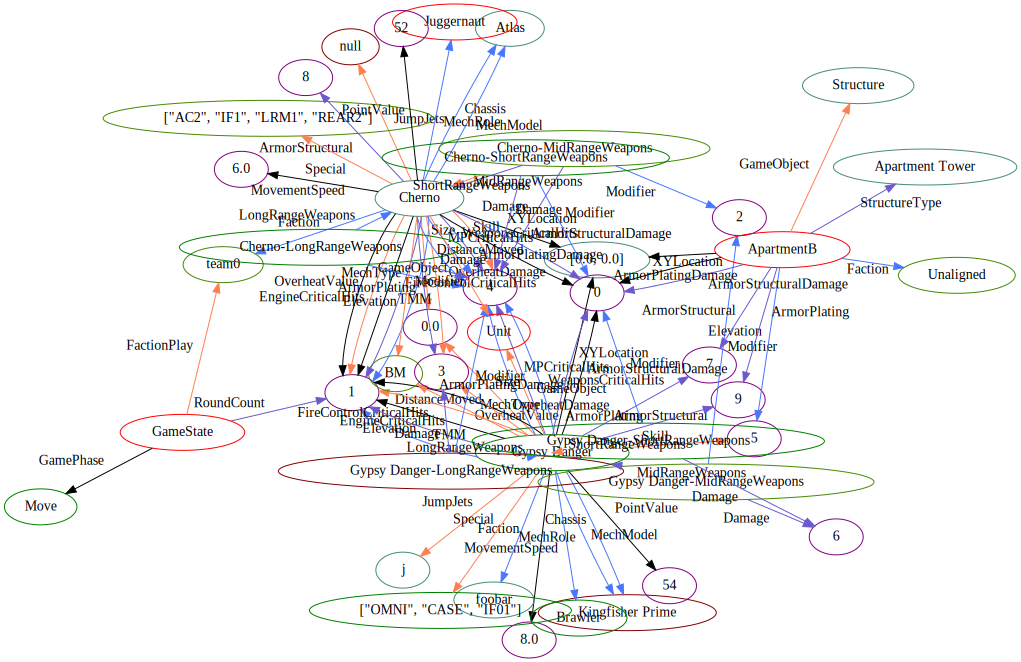

In [5]:
if __name__ == "__main__":
    GameState.reset()
    # Player presses "start" button
    GameState.setFaction("foobar")
    # Player adds 2 objects
    MechFactories['Kingfisher Prime']("Gypsy Danger", "foobar", 5)
    GameState.addObject("Gypsy Danger", "Unit")

    StructureFactories['Apartment Tower']("ApartmentB")
    GameState.addObject("ApartmentB", "Structure")

    # Player ends turn and control passes to other team
    GameState.setFaction("team0")
    MechFactories['Atlas']("Cherno", "team0", 4)
    GameState.addObject("Cherno", "Unit")

    # Player 2 ends turn; move to move phase from Add
    GameState.newPhase("Add")

    display(qs.render())

Gypsy Danger moving to [1, 2, 3]
Cherno moving to [1, 2, 3]
Gypsy Danger    -- Plating:          9 || Plate Damage:          0 -- S:          7 || SD:          0
Cherno          -- Plating:          3 || Plate Damage:          0 -- S:          8 || SD:          0
GameEvents--8db02a26-ebf6-48a2-9d3e-ecb98b3a236a--2025-03-16T21_11_36.204937 result: 6
GameEvents--b077103f-6c81-4184-80ec-34918b6d23e0--2025-03-16T21_11_36.552604 result: 4
Cherno taking damage 6 from short range weapons
Gypsy Danger attack misses Gypsy Danger

# Concluding Phase: Move -- Round 2
Gypsy Danger    -- Plating:          9 || Plate Damage:          0 -- S:          7 || SD:          0
Cherno          -- Plating:          3 || Plate Damage:          3 -- S:          8 || SD:          3
Gypsy Danger Damage: Plating: 0 Structural: 0
Cherno Damage: Plating: 3 Structural: 3


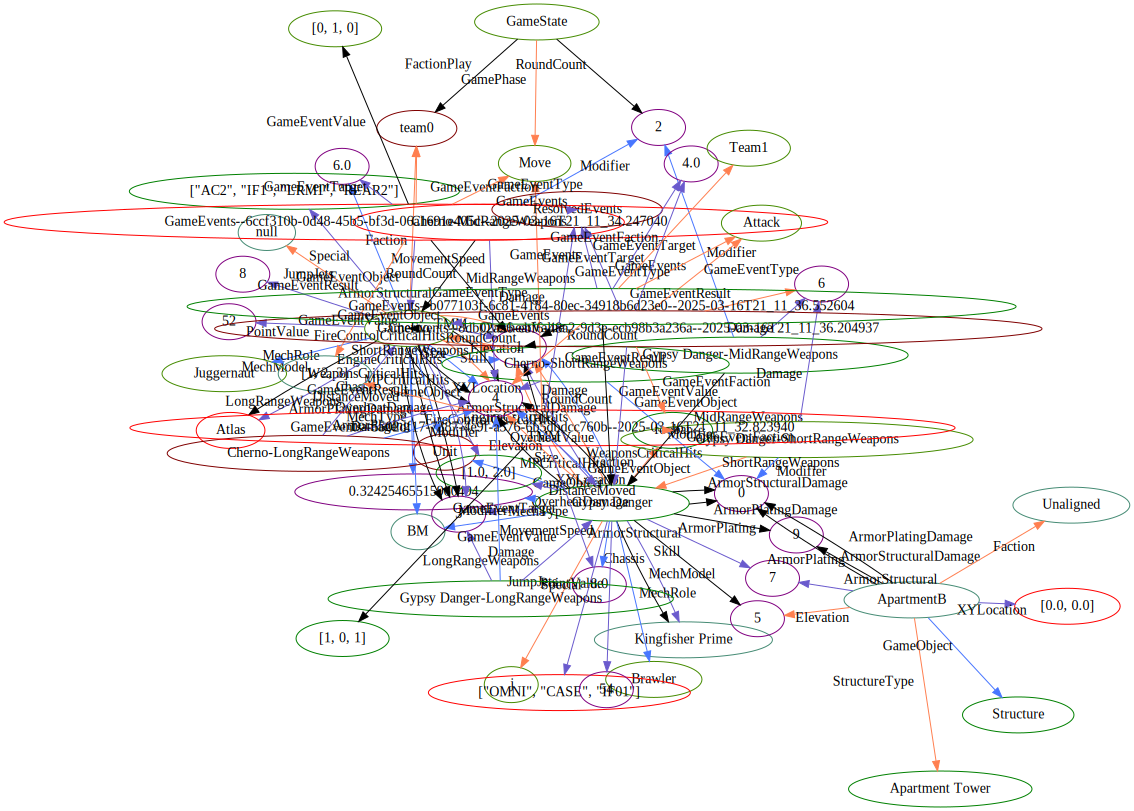

In [6]:
if __name__ == "__main__":
    GameState.setFaction("foobar")
    GameState.declareEvent("Move", "foobar", "Gypsy Danger", "[1, 0, 1]", MovementSpeed("Gypsy Danger").terminant, "[1, 2, 3]")
    # All units from Foobar move or pass
    GameState.setFaction("team0")
    GameState.declareEvent("Move", "team0", "Cherno", "[0, 1, 0]", MovementSpeed("Cherno").terminant, "[1, 2, 3]")
    assert len(GameState.getDeclaredEvents()) == 2
    # All units from Team0 move or pass
    GameState.setFaction("foobar")
    GameState.newPhase("Move")
    GameState.declareEvent("Attack", "foobar", "Gypsy Danger", "Cherno", 4, "null")
    # All units from Team 0 take action or pass
    GameState.setFaction("team0")
    GameState.declareEvent("Attack", "Team1", "Cherno", "Gypsy Danger", 4, "null")

    for r in ["Gypsy Danger", "Cherno"]:
        print(f"{r:15} -- Plating: {ArmorPlating.get_relationship(r):10} || Plate Damage: {ArmorPlatingDamage.get_relationship(r):10} -- S: {ArmorStructural.get_relationship(r):10} || SD: {ArmorStructuralDamage.get_relationship(r):10}") 
    
    GameState.newPhase("Declare")

    for de, result in zip(GameState.getDeclaredEvents(), [6, 4]):
        GameEvent.set_result(gameEvent=de.entity, newResult=str(result))
        print(f"{de.entity} result: {GameEventResult.get_relationship(de.entity)}")
    GameState.newPhase("Action")

    print(f"\n# Concluding Phase: {GamePhase.get_relationship(GameState.__name__)} -- Round {RoundCount.get_relationship(GameState.__name__)}")
    
    for r in ["Gypsy Danger", "Cherno"]:
        print(f"{r:15} -- Plating: {ArmorPlating.get_relationship(r):10} || Plate Damage: {ArmorPlatingDamage.get_relationship(r):10} -- S: {ArmorStructural.get_relationship(r):10} || SD: {ArmorStructuralDamage.get_relationship(r):10}") 
    
    print(f"Gypsy Danger Damage: Plating: {ArmorPlatingDamage.get_relationship('Gypsy Danger')} Structural: {ArmorStructuralDamage.get_relationship('Gypsy Danger')}")
    print(f"Cherno Damage: Plating: {ArmorPlatingDamage.get_relationship('Cherno')} Structural: {ArmorStructuralDamage.get_relationship('Cherno')}")
    display(qs.render())